In [26]:
import scPhyloX as spx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
import os
import pickle
import arviz as az
from scipy.stats import poisson,mannwhitneyu

In [2]:
plt.rcParams['font.size']=12
plt.rcParams['pdf.fonttype']=42

In [3]:
os.chdir('..')

In [16]:
flys = ['L5', 'L6']
organs = 'Br,Ey,Fb,L1,L2,L3,Mp,Sg,Wg'.split(',')

In [18]:
mus = []
fs = []
os = []
for f in flys:
    for o in organs:
        res = pickle.load(open(f'./results/fly_mutrate/mutrate_{f}_{o}.pkl', 'rb'))
        mus.append(res.posterior['mu'].to_numpy().flatten())
        fs.append([f.replace('L5', 'Fly 1').replace('L6', 'Fly 2')]*2000)
        os.append([o]*2000)
mut_data = pd.DataFrame([np.array(mus).flatten(),sum(fs,[]), sum(os, [])]).T
mut_data.columns = ['mutrate', 'fly', 'organ']
mut_data['mutrate']=mut_data['mutrate'].astype('float')

Text(0.5, 0, '')

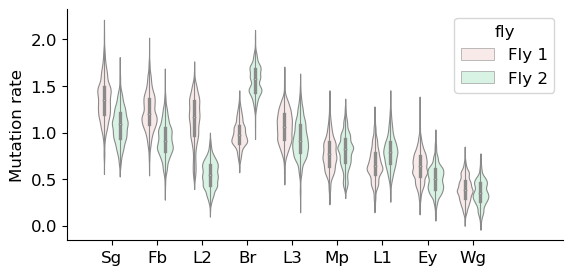

In [21]:
fig, ax = plt.subplots(figsize=(6.4, 3))
sns.violinplot(mut_data, y='mutrate', x='organ', hue='fly', ax=ax, inner='box',
               linewidth=0.8, width=0.7,palette=['#FBE8E8','#D3F8E2'],
               order=['Sg','Fb','L2','Br','L3','Mp','L1','Ey','Wg']
              )
sns.move_legend(ax, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((-1,10))
ax.set_ylabel('Mutation rate')
ax.set_xlabel('')

Text(0, 0.5, 'Fly 2')

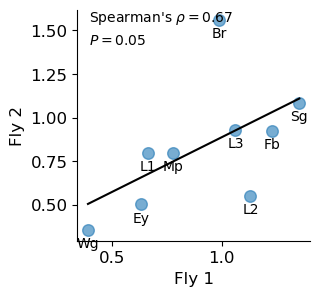

In [23]:
fig, ax = plt.subplots(figsize=(3,3))
mu5 = mut_mean['L5'].to_numpy().astype(float)
mu6 = mut_mean['L6'].to_numpy().astype(float)
spx.utils.corr_plot(mu5, mu6, ax=ax,stats='spearmanr')
for i, o in enumerate(mut_mean.index):
    ax.text(mut_mean.iloc[i,0], mut_mean.iloc[i,1]-0.1, o, horizontalalignment='center', fontsize=10)
ax.set_xlabel('Fly 1')
ax.set_ylabel('Fly 2')

100%|██████████| 66795/66795 [00:01<00:00, 44035.09it/s]


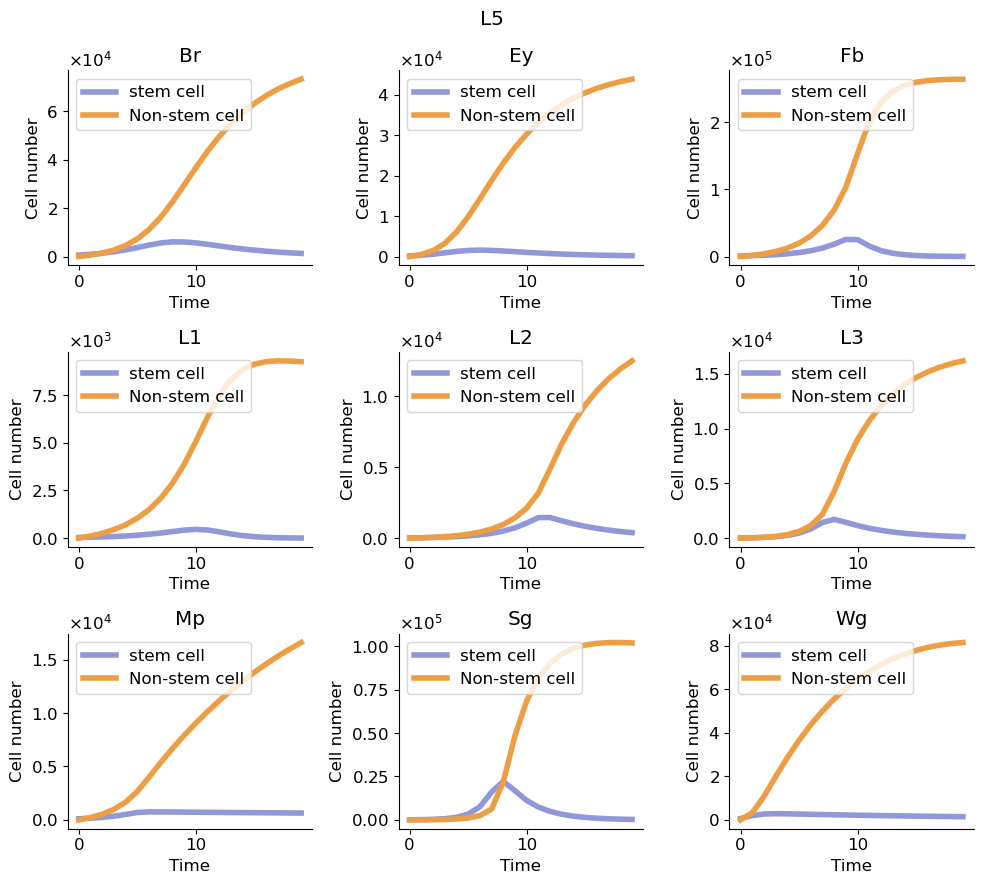

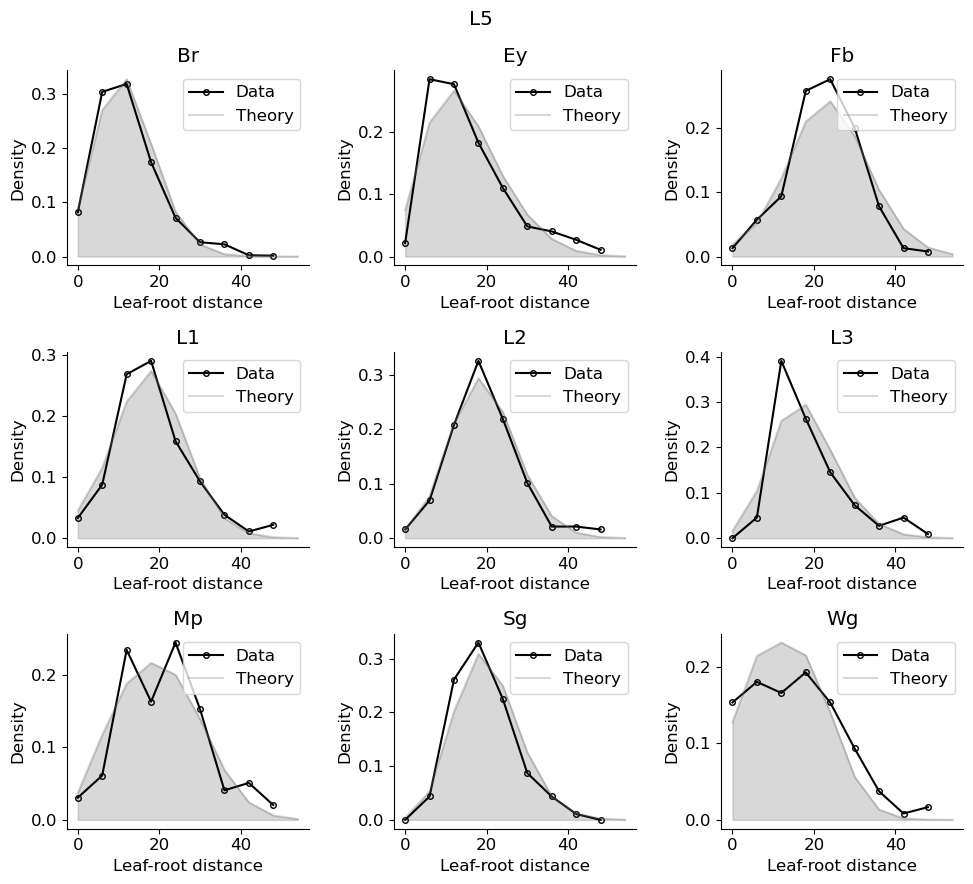

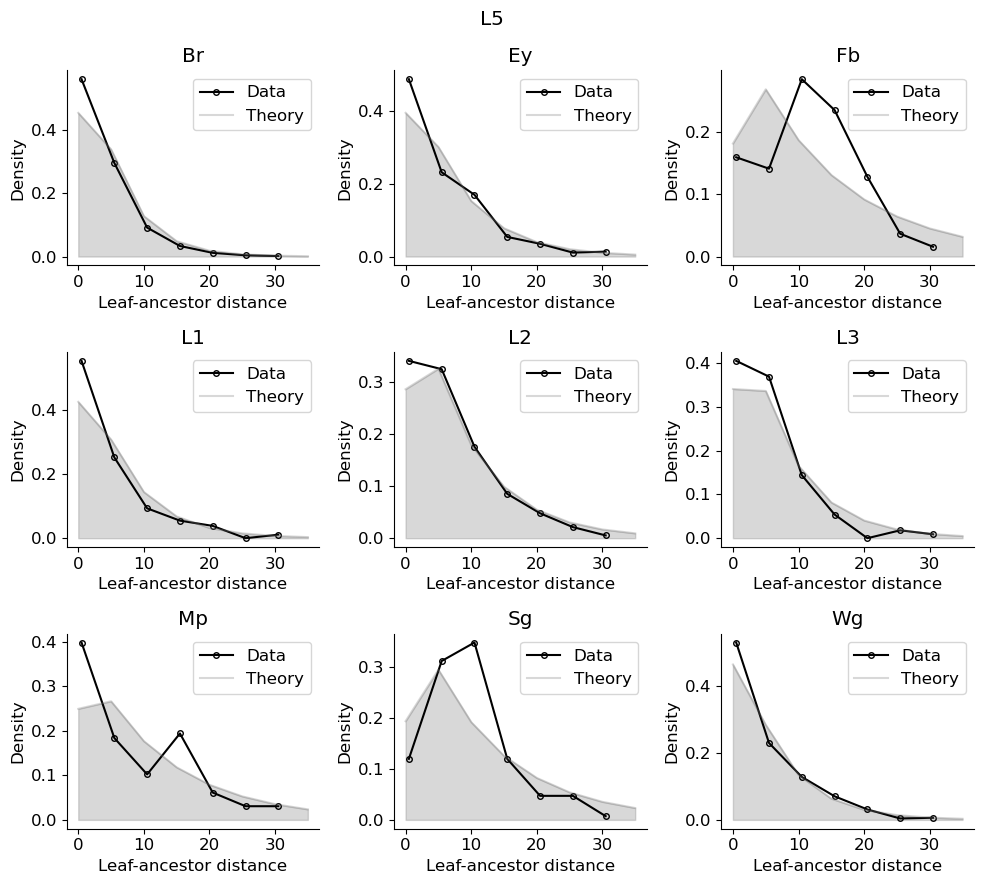

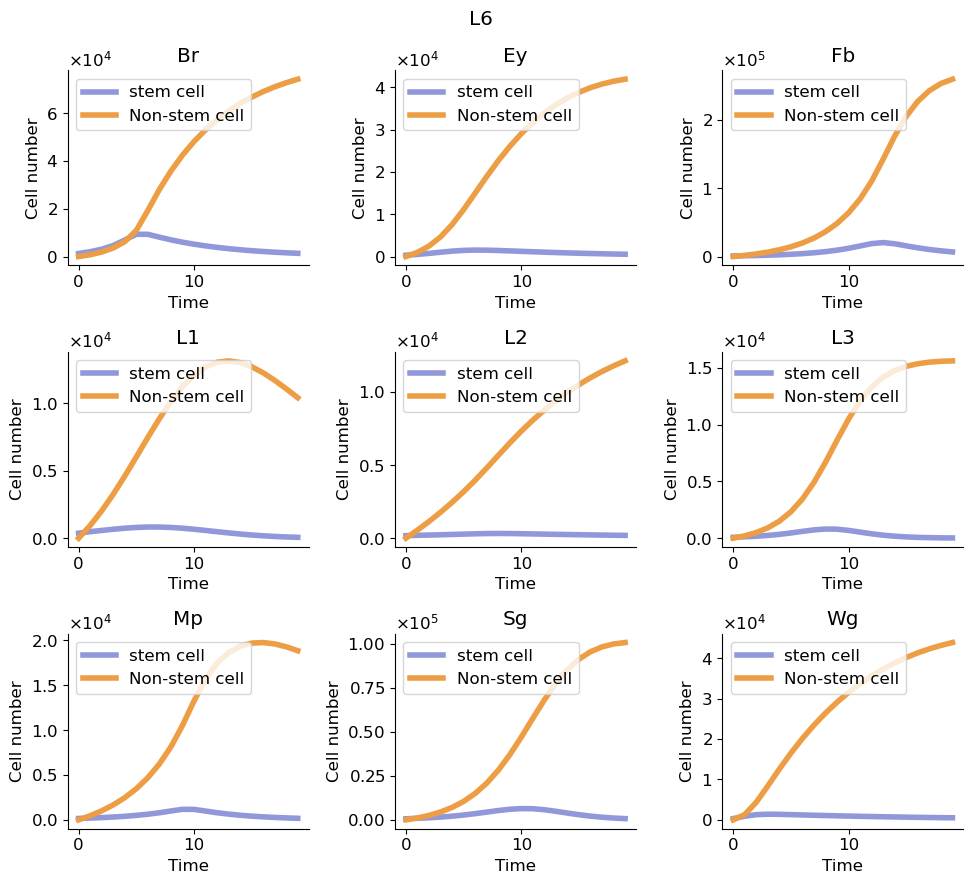

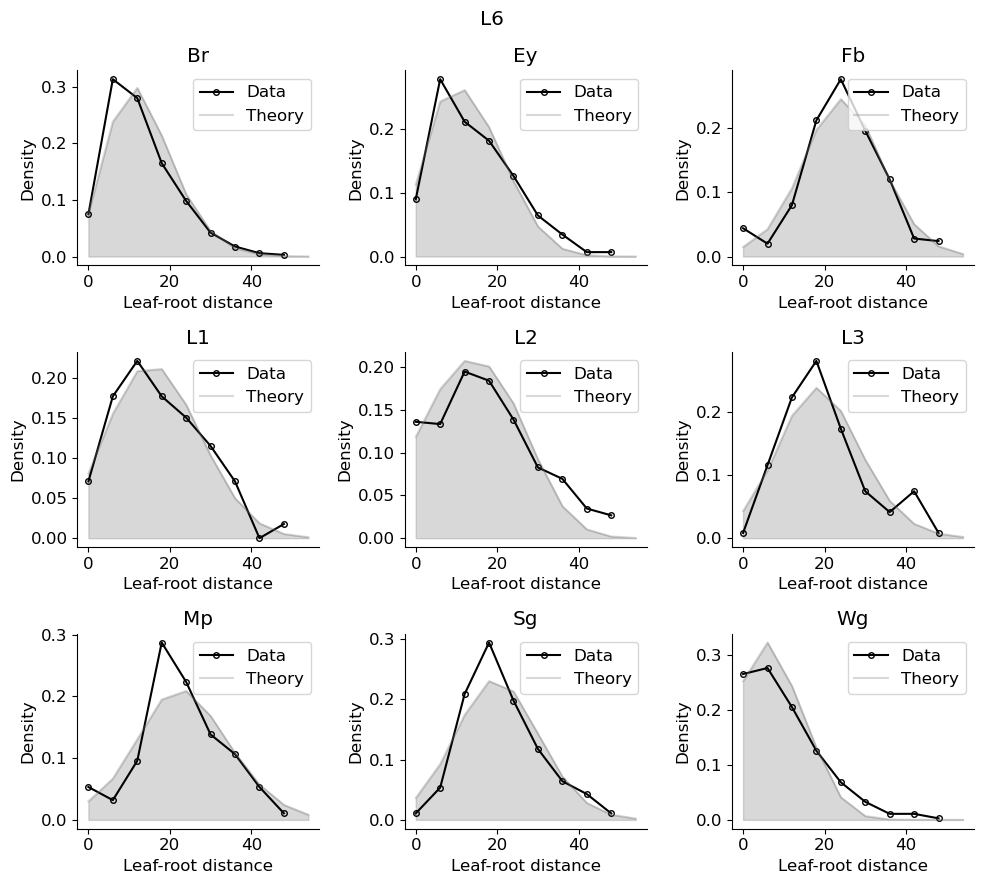

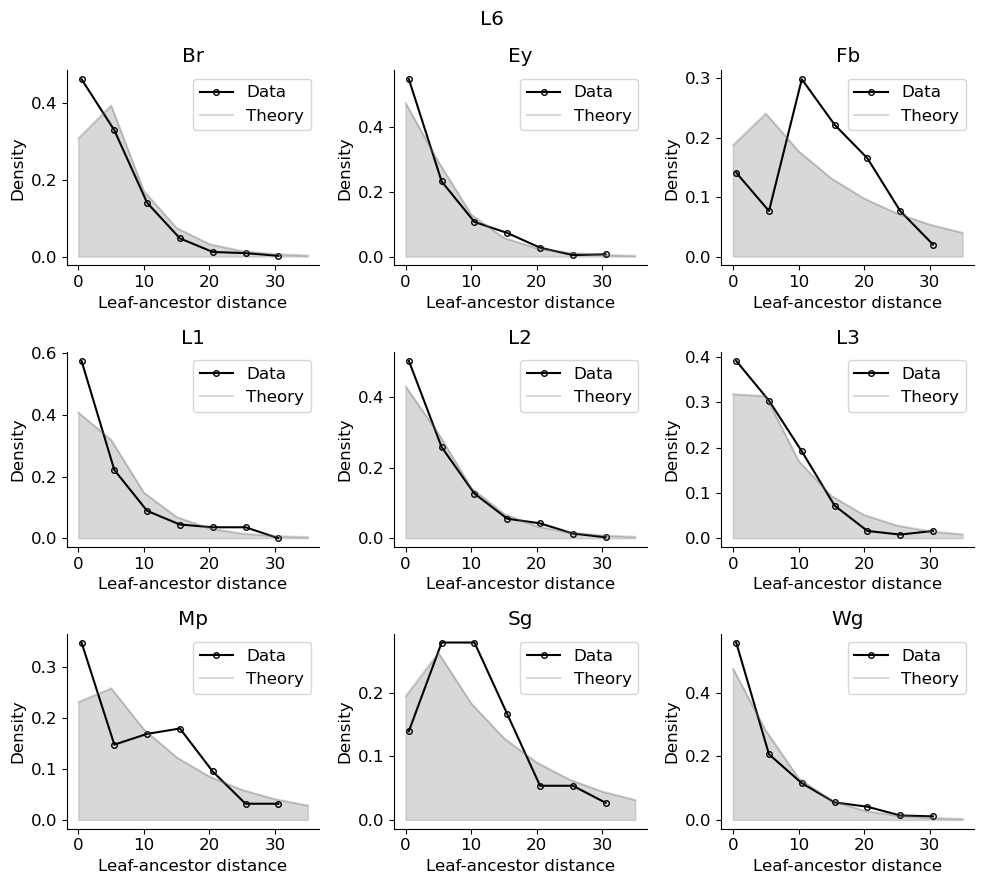

In [15]:
population_size = spx.data_factory.population_size

for fly in ['L5', 'L6']:
    fig1, ax1 = plt.subplots(3,3, figsize=(10, 9))
    fig2, ax2 = plt.subplots(3,3, figsize=(10, 9))
    fig3, ax3 = plt.subplots(3,3, figsize=(10, 9))
    for ind, organ in enumerate(population_size):
        mutnum = spx.data_factory.mutnum_fly(f'./datasets/FLY/pre_processed/{fly}/{organ}.txt.gz', './datasets/FLY/pre_processed/ref')
        branchlen = spx.data_factory.branchlen_fly(f'./datasets/FLY/pre_processed/{fly}/{organ}.txt.gz', './datasets/FLY/pre_processed/ref')
        N, sr = population_size[organ], len(mutnum)/population_size[organ]
        c0_all = pd.read_csv('./results/fly_dynpara/c0.csv', index_col=0, header=None)
        c0 = c0_all.loc[f'{fly}{organ}'][1]
        mutrate = pd.read_csv(f'./results/fly_mutrate/mutrate_{fly}_{organ}.csv')
        muh, betah = mutrate['mean']
        ge = spx.est_mr.GenerationEst(mutnum, muh)
        gen_num = ge.estimate(N)
        T = 20
        idata = pickle.load(open(f'./results/fly_dynpara/{fly}{organ}', 'rb'))
        theta_h = az.summary(idata).loc['ax,bx,r,d,k,t0'.split(',')]['mean'].to_numpy().tolist()
        
        
        x0 = [c0, 0]
        n_stemcells = np.array([[spx.est_tissue.ncyc(i, j, c0, *theta_h) for j in range(T)] for i in range(max(100, len(gen_num)))])
        n_nonstemcells = np.array([[spx.est_tissue.nnc(i, j, c0, *theta_h) for j in range(T)] for i in range(max(100, len(gen_num)))])
        alpha = n_stemcells[:,-1]+n_nonstemcells[:,-1]
        alpha = alpha / sum(alpha)
        
        max_val = 60
        n_hist = 10
        mutdist = np.histogram(mutnum, np.arange(0, max_val, int(max_val/n_hist)))
        th_dist = np.zeros(max_val)
        for i, a in enumerate(alpha):
            th_dist = th_dist + a*poisson((i+1)*muh).pmf(range(max_val))
        th_dist_x = []
        th_dist_y = []
        for i in range(n_hist):
            th_dist_x.append(i*int(max_val/n_hist))
            th_dist_y.append(np.sum(th_dist[i*int(max_val/n_hist):(i+1)*int(max_val/n_hist)]))
    
        # fig, ax = plt.subplots(1, 1, figsize=(3.2,3))

        ax1[ind//3][ind%3].set_xlabel('Time')
        ax1[ind//3][ind%3].set_ylabel('Cell number')
        ax1[ind//3][ind%3].plot(n_stemcells.sum(0), c='#9098d9', lw=4, label='stem cell')
        ax1[ind//3][ind%3].plot(n_nonstemcells.sum(0), c='#ed9e44', lw=4, label='Non-stem cell')
        ax1[ind//3][ind%3].ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
        ax1[ind//3][ind%3].spines['right'].set_visible(False)
        ax1[ind//3][ind%3].spines['top'].set_visible(False)
        ax1[ind//3][ind%3].legend(loc=2)
        ax1[ind//3][ind%3].ticklabel_format (style='sci', scilimits= (-1,2), axis='y', useMathText=True)
        ax1[ind//3][ind%3].set_title(organ)

        
        ax2[ind//3][ind%3].plot(mutdist[1][:-1], mutdist[0]/sum(mutdist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
        ax2[ind//3][ind%3].plot(th_dist_x, th_dist_y, c='tab:grey',alpha=0.3, label='Theory')
        ax2[ind//3][ind%3].fill_between(th_dist_x, th_dist_y, color='tab:grey', alpha=0.3)
        ax2[ind//3][ind%3].spines['right'].set_visible(False)
        ax2[ind//3][ind%3].spines['top'].set_visible(False)
        ax2[ind//3][ind%3].set_xlabel('Leaf-root distance')
        ax2[ind//3][ind%3].set_ylabel('Density')
        ax2[ind//3][ind%3].legend(loc=1)
        ax2[ind//3][ind%3].set_title(organ)

        
        max_bl = 40
        n_hist = 8
        xrange = np.arange(0, max_bl, max_bl//n_hist)
        th_dist = np.array([spx.est_mr.BranchLength(muh, betah).prob(i) for i in xrange])
        th_dist = th_dist/sum(th_dist)
        
        hist = np.histogram(branchlen, xrange)
        ax3[ind//3][ind%3].plot(xrange[:-1]+0.5, hist[0]/sum(hist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
        ax3[ind//3][ind%3].plot(xrange, th_dist, c='tab:grey',alpha=0.3, label='Theory')
        ax3[ind//3][ind%3].fill_between(xrange, th_dist, color='tab:grey', alpha=0.3)
        ax3[ind//3][ind%3].spines['right'].set_visible(False)
        ax3[ind//3][ind%3].spines['top'].set_visible(False)
        ax3[ind//3][ind%3].set_xlabel('Leaf-ancestor distance')
        ax3[ind//3][ind%3].set_ylabel('Density')
        ax3[ind//3][ind%3].legend(loc=1)
        ax3[ind//3][ind%3].set_title(organ)
    fig1.suptitle(fly)
    fig2.suptitle(fly)
    fig3.suptitle(fly)
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()


In [25]:
para_df = pd.DataFrame(columns=['fly', 'organ'] + 'ax,bx,r,d,k,t0'.split(','))
cnt = 0
for fly in ['L5', 'L6']:
    for organ in population_size:
        idata = pickle.load(open(f'./results/fly_dynpara/{fly}{organ}', 'rb'))
        theta_h = az.summary(idata).loc['ax,bx,r,d,k,t0'.split(',')]['mean'].to_numpy().tolist()
        para_df.loc[cnt] = [fly,  organ, *theta_h]
        cnt += 1
        c0_all = pd.read_csv('./results/fly_dynpara/c0.csv', index_col=0, header=None)
        c0 = c0_all.loc[f'{fly}{organ}'][1]
        
r_os = []
for fly in ['L5', 'L6']:
    for organ in population_size:
        idata = pickle.load(open(f'./results/fly_dynpara/{fly}{organ}', 'rb'))
        theta_h = az.summary(idata).loc['ax,bx,r,d,k,t0'.split(',')]['mean'].to_numpy().tolist()
        x0 = [c0, 0]
        n_cyclingcells = np.array([[spx.est_tissue.ncyc(i, j, c0, *theta_h) for j in range(T)] for i in range(max(100, len(gen_num)))])
        r_os.append(np.max(n_cyclingcells.sum(0))/n_cyclingcells.sum(0)[-1])

Text(-0.3, 0.075, '$P=0.006$')

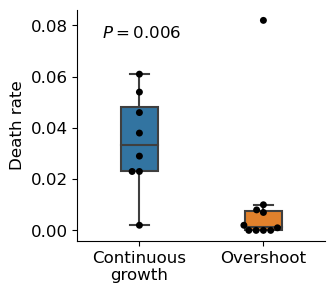

In [28]:
fig, ax = plt.subplots(figsize=(3.2,3))
d_con, d_os = para_df[para_df['bx']>0.85]['d'].to_numpy(), para_df[para_df['bx']<0.85]['d'].to_numpy()
sns.boxplot([d_con, d_os], width=0.3, fliersize=0)
sns.swarmplot([d_con, d_os], palette=['#000000', '#000000'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(['Continuous\ngrowth', 'Overshoot'])
ax.set_ylabel('Death rate')
r, pval = mannwhitneyu(d_con, d_os, alternative='greater')
ax.text(-0.3, 0.075, r'$P={:.3f}$'.format(pval))

Text(0, 0.5, 'Fly 2')

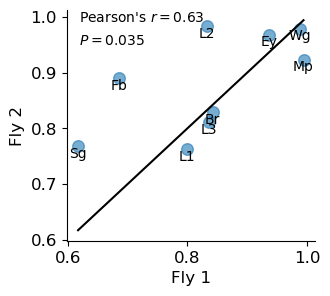

In [30]:
bx5, bx6 = para_df[para_df['fly']=='L5']['bx'].to_numpy(), para_df[para_df['fly']=='L6']['bx'].to_numpy()
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(bx5, bx6, ax=ax, stats='pearson', line='diag', alternative='greater')
for i, o in enumerate(para_df[para_df['fly']=='L5']['organ']):
    ax.text(bx5[i], bx6[i]-0.02, o, horizontalalignment='center', fontsize=10)
ax.set_xlabel('Fly 1')
ax.set_ylabel('Fly 2')